# Harmonic splitter

Go through either experimental or simulation data to isolate the frequencies.

Note that the first will always be a DC using a window of f_min - delta

## Script parameters

In [17]:
# output to screen (useful if interactive)
iOutputToScreen = True
# output plots to screen (useful if interactive)
plotInteractive = True
# default to non script mode 
# (corrected later if this is called from script.sh)
iScriptMode = False

### Load packages

In [18]:
# import required python packages
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq
import sys

## Read settings

Read file names and parameters from settings file made by GenerateScript

Filenames set by input argument either simulation or experiment

In [19]:
lines = [line.rstrip('\n') for line in open('Settings.inp')]
raw_data_exp = lines[0].strip().split()[0]
raw_data_sim = lines[1].strip().split()[0]
number_harmonics = int(lines[2].strip().split()[0])
frequency_bandwidth = float(lines[3].strip().split()[0])
filename_exp = lines[4].strip().split()[0]
filename_sim = lines[5].strip().split()[0]
results_name = lines[6].strip().split()[0]

## Simulation or experiment inputs

Take arguments from command line. Argument specifies which filename to select.

In [20]:
filename_out = filename_sim
data_input = raw_data_sim
if(len(sys.argv)>1):
    if(sys.argv[1]=='-script'):
        iScriptMode = True
        iOutputToScreen = False
        plotInteractive = False
        filename_out = filename_sim
        data_input = raw_data_sim
        if(len(sys.argv)>2):
            if(sys.argv[2]=='-exp'):
                filename_out = filename_exp
                data_input = raw_data_exp

## Output summary


In [32]:
if(iOutputToScreen):
    print "Harmonics: ", filename_out, data_input
    print "with args: ", sys.argv

Harmonics:  Smoothed.txt MECSimOutput_Pot.txt
with args:  ['C:\\Users\\gk250818\\AppData\\Local\\Continuum\\Anaconda2\\lib\\site-packages\\ipykernel\\__main__.py', '-f', 'C:\\Users\\gk250818\\AppData\\Roaming\\jupyter\\runtime\\kernel-19648118-a9cf-4b0a-9f4f-7d196691a8fc.json']


## Define functions

Read the data file using the format from POT software also used as default by MECSim. Time, current then applied potential

In [22]:
# load POT output file
def ReadPOTFileFreq(filename):
    f = open(filename, 'r')
    time = []
    eapp = []
    current = []
    freq = []
    amp = []
    phase = []
    nfreq = 0
    iCount = 0
    iAll = 0
    for line in f:
        columns = line.split()
        if(columns[0][3:7].isdigit()): # look at 2nd character in case Eapp is "-"
            thisTime = float(columns[2])
            time.append(thisTime)
            eapp.append(float(columns[0]))
            current.append(float(columns[1]))
            iCount += 1
        else:
            if(columns[0][0:3]=='Fre'):
                freq.append(float(columns[1]))
            if(columns[0][0:3]=='Amp'):
                amp.append(float(columns[1]))
                if(amp[-1]!=0.0):
                    nfreq += 1
            if(columns[0][0:3]=='Pha'):
                phase.append(float(columns[1])) # not always there
        iAll += 1
    return iCount, nfreq, freq, amp, time, current, eapp

Smooth the current as an envelope of the current as a function of time

In [23]:
def SmoothCurrent(t, i, e, tWindow):
    iSmooth = list(i)
    deltaT = t[1]-t[0] # assumes constant time steps
    tEnd = t[-1]
    tStart = t[0]
    iWindow = int(tWindow/deltaT)+1
    windowVal = []
    iMax = len(t)
    iMinW = -iWindow/2
    iMaxW = iMinW+iWindow-1
    for j in range(0, iWindow):
        windowVal.insert(0, i[j]) # insert at top/pop from bottom
    for ii in range(iMax):
        iMinW += 1
        iMaxW += 1
        if((iMinW>0) and (iMaxW<iMax)): # shift running total across by one point
            windowVal.pop()
            windowVal.insert(0, i[iMaxW])
        iSmooth[ii] = max(windowVal)
    return iSmooth

## Read data file

Read in data from the POT file

In [24]:
iCount, nfreq, freq, amp, time, current, eapp = ReadPOTFileFreq(data_input)
t = np.array(time)
c = np.array(current)
ea = np.array(eapp)

Length of data

In [25]:
n_data_length = len(t)

## Setup smoothing window

Use the minimum fundamental frequency to smooth over a single cycle using a moving average.

In [26]:
freqMin = min(freq[0:nfreq])
tWindow = 1.0/freqMin
if(iOutputToScreen):
    print 'f_min = ',freqMin,' ; t_window = ',tWindow

f_min =  22.01647  ; t_window =  0.0454205419852


FFT of the time series data
---

Single frequency is assumed for now. Do all harmonics of it (and dc).

DC isolation goes up to the lowest frequency with some buffer.

Moving average smoothing applied to resulting frequency filtered current signal back in the time domain.

In [27]:
i_Harm = []
c_Harm = []

# isolate dc ramp component
W = fftfreq(c.size, d=2*(t[1]-t[0]))
f_signal = rfft(c)
cut_f_signal = f_signal.copy()
#cut_f_signal[(W>0.5*freqMin)] = 0
cut_f_signal[(W>freqMin-frequency_bandwidth)] = 0
cut_signal = irfft(cut_f_signal)

c_Harm.append(cut_signal)
i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))

# now for the harmonics
for iH in range(number_harmonics):
    iHarm = iH + 1
    fH = float(iHarm)
    W = fftfreq(c.size, d=2*(t[1]-t[0]))
    f_signal = rfft(c)
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W<(fH*freq[0]-frequency_bandwidth))] = 0
    cut_f_signal[(W>(fH*freq[0]+frequency_bandwidth))] = 0
    cut_signal = irfft(cut_f_signal)
    c_Harm.append(cut_signal)
    i_Harm.append(SmoothCurrent(t, cut_signal, eapp, tWindow))


## Save smoothed harmonic data

In [28]:
data_output = t
for i in range(number_harmonics+1):
    data_output = np.concatenate((data_output, i_Harm[i]), axis=0)

data_output = np.reshape(data_output, (number_harmonics+2, n_data_length))
data_output = data_output.T
np.savetxt(filename_out, data_output)

## Use interactive plotter

ONLY if not using this in bash script

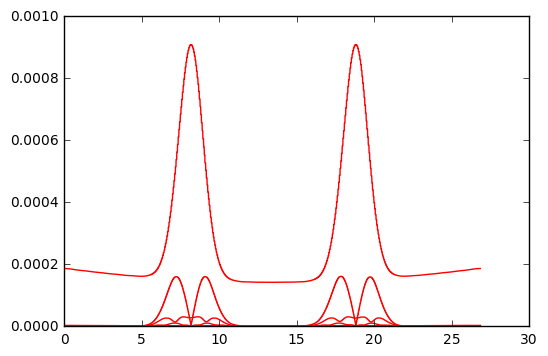

In [29]:
if(plotInteractive):
    import matplotlib.pyplot as plt
    %matplotlib inline
    for i in range(number_harmonics):
        iH = i+1
        plt.plot(t, i_Harm[iH],c='r')
    plt.show()

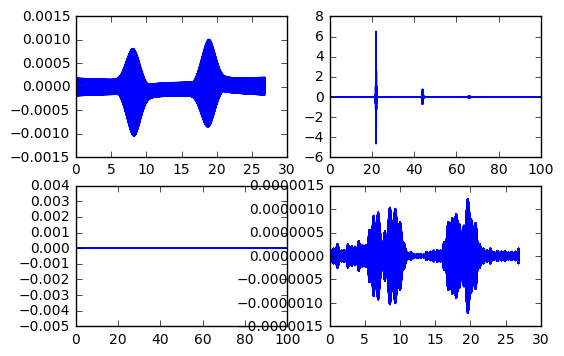

In [30]:
if(plotInteractive):
    plt.subplot(221)
    plt.plot(t,c)
    plt.subplot(222)
    plt.plot(W,f_signal)
    plt.xlim(0,100)
    plt.subplot(223)
    plt.plot(W,cut_f_signal)
    plt.xlim(0,100)
    plt.subplot(224)
    plt.plot(t,cut_signal)
    plt.show()

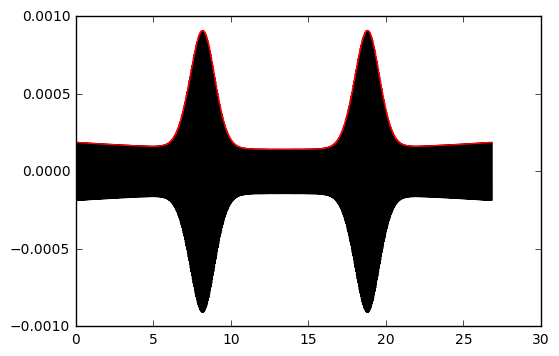

In [31]:
if(plotInteractive):
    iH = 1
    plt.plot(t, c_Harm[iH],c='k')
    plt.plot(t, i_Harm[iH],c='r')
    plt.show()